In [1]:
%env CUDA_VISIBLE_DEVICES=0
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

env: CUDA_VISIBLE_DEVICES=0


Autosaving every 180 seconds


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pylab as plt
import src as ut

In [3]:
from os import listdir

files_image = ['data/images/' + f for f in listdir('data/images')]
files_model = ['data/models/' + f for f in listdir('data/models')]

mask = None
image = None

for fm, fi in zip(files_model, files_image):
    if not isinstance(mask, np.ndarray):
        mask, image = ut.create_dataset_classification(fm, fi)
        continue
    _msk, _img = ut.create_dataset_classification(fm, fi)
    mask = np.concatenate([mask, _msk], axis=0)
    image = np.concatenate([image, _img], axis=0)
    
mask, image = ut.augmentate_dataset_classification(mask, image)

# Create datasets

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
depth_window = 128
step = 128

n_depth, n_angle = image.shape
depth_interval = np.arange(depth_window)
depth_slice_start = np.arange(0, n_depth-depth_window, step)
slices = depth_slice_start[...,None] + depth_interval[None,...]

image_slices = image[slices].copy()
mask_slices = mask[slices].copy()

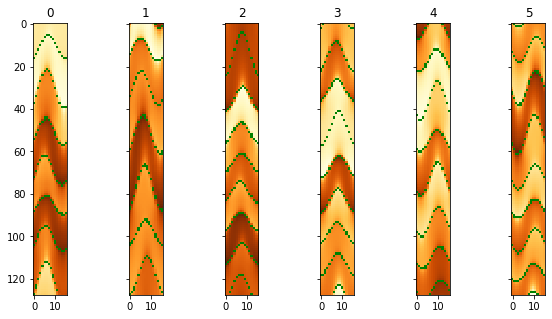

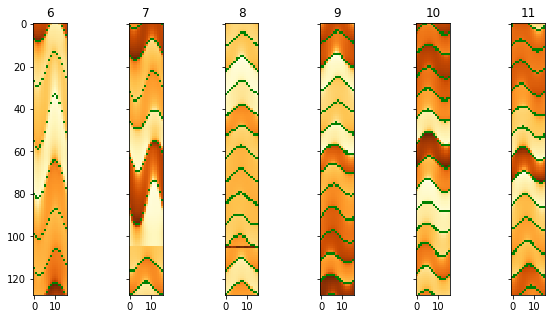

In [6]:
ut.plot_dashboard(image_slices[:12], mask_slices[:12])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(image_slices, mask_slices, test_size=.2)
print('Train shapes x{}, y{}'.format(X_train.shape, y_train.shape))
print('Test shapes x{}, y{}'.format(X_test.shape, y_test.shape))

Train shapes x(600, 128, 16), y(600, 128, 16)
Test shapes x(150, 128, 16), y(150, 128, 16)


# Build CNN model

In [8]:
from keras_models import model_classification, PlotLosses
from tensorflow.keras.utils import to_categorical

In [9]:
model = model_classification(
    2, 
    shape=None,
    filters=[32]*4,
    kernel_size=[3,3,3],
    activation=['relu']*4,
    last_kernel_size=3,
    last_activation='softmax',
    dropout=None, 
    batch_norm=True,
    lr=.005,
    decay=0.00,
)
epoch = 0
model.summary()

Model: "conv_segm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None)]      0         
_________________________________________________________________
lambda (Lambda)              (None, None, None, 1)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    320       
_________________________________________________________________
activation (Activation)      (None, None, None, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 32)    128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 32)    0 

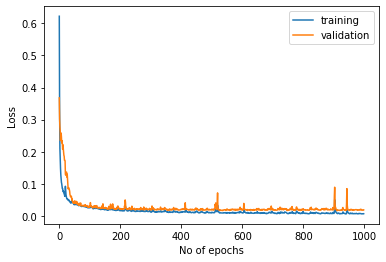

600/600 [==============================] - 0s 432us/sample - loss: 0.0067 - ssim: 0.9755 - accuracy: 0.9978 - precision: 0.9895 - recall: 0.9777 - fbeta_score: 0.9449 - val_loss: 0.0186 - val_ssim: 0.9769 - val_accuracy: 0.9954 - val_precision: 0.9730 - val_recall: 0.9585 - val_fbeta_score: 0.8726
Epoch 1000/1000
600/600 [==============================] - 0s 273us/sample - loss: 0.0062 - ssim: 0.9749 - accuracy: 0.9979 - precision: 0.9898 - recall: 0.9803 - fbeta_score: 0.9507 - val_loss: 0.0187 - val_ssim: 0.9816 - val_accuracy: 0.9955 - val_precision: 0.9767 - val_recall: 0.9568 - val_fbeta_score: 0.8778


In [10]:
model.fit(
        x=X_train, 
        y=to_categorical(y_train, num_classes=2), 
        batch_size=64, 
        epochs=1000, 
        verbose=1, 
        callbacks=[PlotLosses()], 
        validation_split=0.0, 
        validation_data=[X_test, to_categorical(y_test, num_classes=2)], 
        shuffle=True, 
        class_weight=None, 
        sample_weight=None, 
        initial_epoch=0, 
        steps_per_epoch=None, 
        validation_steps=None,
    )

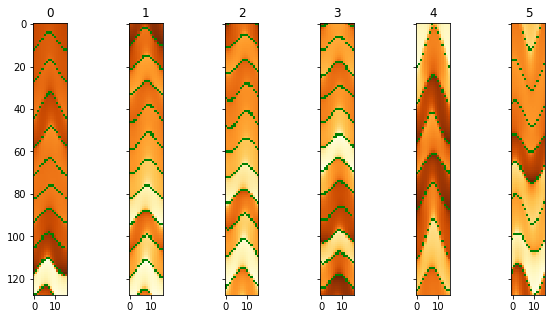

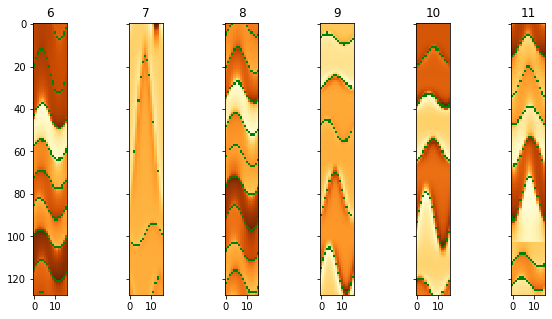

In [11]:
y_pred = model.predict(X_test[:12])
ut.plot_dashboard(X_test[:12], y_pred[...,1]>.6)

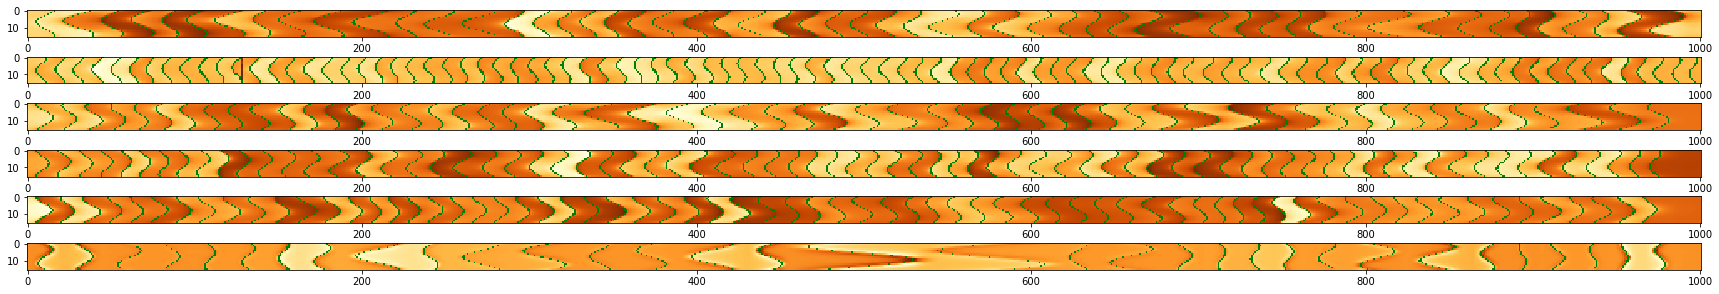

In [12]:
fig, axs = plt.subplots(nrows=len(files_image), ncols=1, figsize=(30,5), facecolor='w')
for i, (fm, fi) in enumerate(zip(files_model, files_image)):
    mask, img = ut.create_dataset_classification(fm, fi)
    pred = model.predict(img[None,...])[0,...,1]>.5
#     pd.DataFrame(pred).to_csv(fi.split('.')[0] + '_pred.csv')
    ut.plot_image(img, pred, axs[i])